#  Проект "Определение возраста покупателей по фото"


Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
 - Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
 - Контролировать добросовестность кассиров при продаже алкоголя.
 
**Данные:**
 - набор фотографий людей с указанием возраста.

**Задача:**
 - Построить модель, которая по фотографии определит приблизительный возраст человека. 

**Порядок по выполнению проекта**:
 - исследовательский анализ набора фотографий и подготовка данных к обучению,
 - обучение нейронной сети и оценка её качество (значения MAE на тестовой выборке не больше 8).


## Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import seaborn as sns
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

Проведем исследовательский анализ данных:
 - оценим размер выборки,
 - построим график распределения возраста в выборке,
 - напечатаем на экране 10–15 фотографий и посмотрим, как устроен датасет,
 - сделаем выводы о том, как результаты исследования повлияют на обучение модели.

In [2]:
#загрузим данные из файла 
data = pd.read_csv('/datasets/faces/labels.csv')
#выведем любые 5 строк
data.sample(5)

,file_name,real_age
5615,005615.jpg,40
835,000835.jpg,18
6630,006635.jpg,40
6331,006335.jpg,24
1596,001596.jpg,5


In [3]:
#выгрузим инфо о файле с фото
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
#выведем статистику по возрасту
data.describe().T

,count,mean,std,min,25%,50%,75%,max
real_age,"7,591.00",31.20,17.15,1.00,20.00,29.00,41.00,100.00


Данные с фото представлены 7591-й фотографиями, пропуски отсутствуют, столбец с возрастом представлен целочисленным форматом.

Возраст находится в диапазоне от 1 до 100 лет, медиана - 29 лет, средний возраст - 31.

Оценим распределение возраста

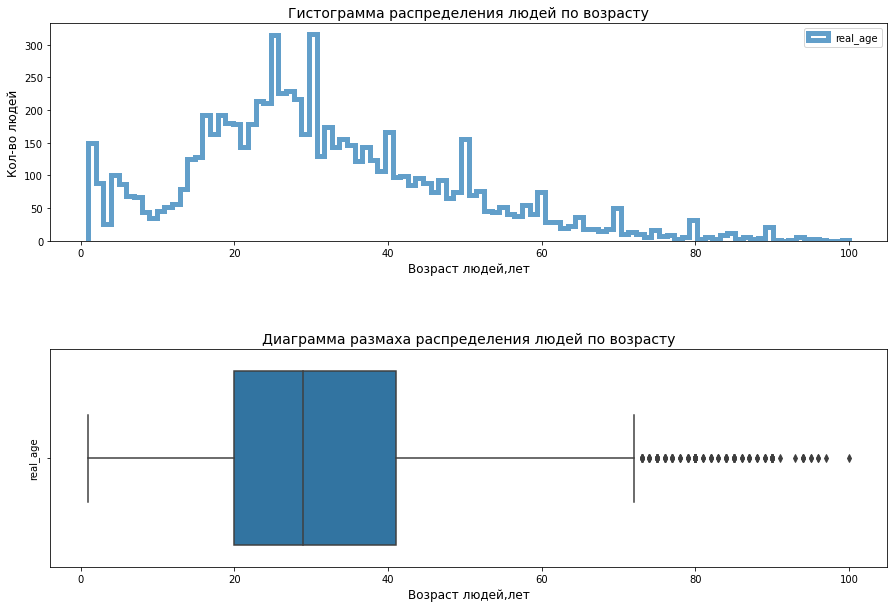

In [5]:
#выведем распределение по возрасту в виде гистограммы и боксплота
fig, ax = plt.subplots(figsize = (15, 10));
ax = plt.subplot(2,1,1)

data.plot(kind='hist',y='real_age',histtype='step',bins=100,linewidth=5,alpha=0.7,ax=ax);
plt.ylabel('Кол-во людей', fontsize=12);
plt.xlabel('Возраст людей,лет', fontsize=12);
plt.title('Гистограмма распределения людей по возрасту',fontsize=14);
plt.subplots_adjust(wspace=0.5,hspace = 0.5);

sns.boxplot(data['real_age'], ax = plt.subplot(2,1,2));
plt.ylabel('real_age')
plt.xlabel('Возраст людей,лет', fontsize=12);
plt.title('Диаграмма размаха распределения людей по возрасту',fontsize=14);

Распределение по возрасту является нормальным с "хвостом" справа,75% данных в интерале до 41 года, значения свыше 66 лет оцениваются на боксплоте как выбросы.

In [6]:
# инициируем загрузчик
datagen = ImageDataGenerator(rescale=1./255)
#извлечем данные из папки
datagen_flow = datagen.flow_from_dataframe(
    dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [7]:
#получим объект пары «картинки — метки» 
features, target = next(datagen_flow)
features.shape

(32, 224, 224, 3)

Извлечены все 7591 фото, по 32 фото в батче размером 224 на 224 пикселей,это цветные изображения из 3-х каналов.

Напечатаем на экране 12 фотографий и сделаем выводы о том, как результаты исследования повлияют на обучение модели.

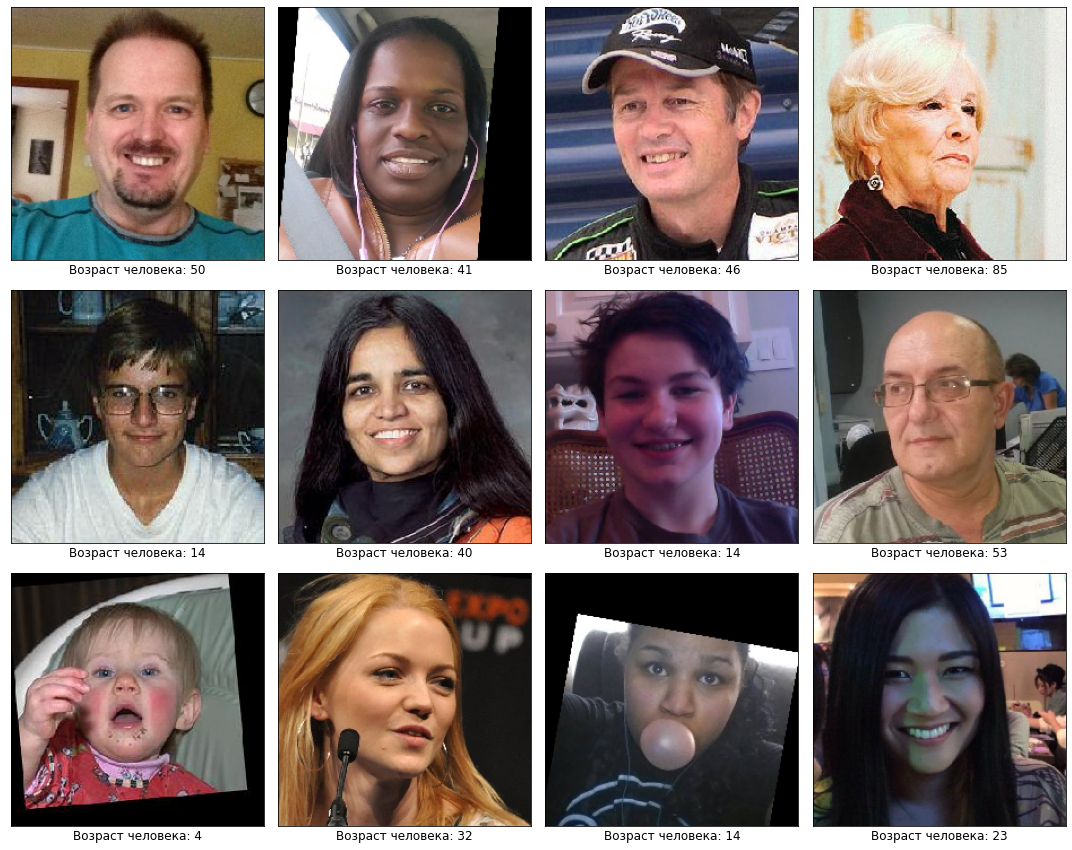

In [8]:
# выводим 12 изображений
fig = plt.figure(figsize=(15,12))
for i in range(12):
    fig.add_subplot(3, 4, i+1)
    plt.imshow(features[i])
    plt.xlabel(f'Возраст человека: {target[i]}',fontsize=12)
	# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Исходя из выгруженных фото видно, что:
 - не все фото размечены корректно. 
 - на фото присутствуют посторонние предметы, 
 - не все фото четкие.
 
Все это по совокупности может затруднить обучение модели.

**Вывод по исследовательскому анализу**:

 - данные для обучения представлены 7591 фото,
 - возраст находится в диапазоне от 1 до 100 лет, медиана - 29 лет, средний возраст - 31.75% данных в интервале до 41 года, значения свыше 66 лет оцениваются на боксплоте как выбросы.
 - исходя из выгруженных примеров фото, обучение модели может затруднить следующее:не все фото размечены корректно (применим агументацию в виде поворотов), 
на фото присутствуют посторонние предметы, не все фото четкие.

## Обучение модели

Используем модель сверточной нейронной сети построенной на ResNet50, использованно 6 эпох и аугментация в виде горизонтального поворота фотографий.

Перенесем сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, Dense, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd


def load_train(path):
    data = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=data,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow


def load_test(path):
    data = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=data,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=3e-4)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])
    
    return model


def train_model(model, train_data, test_data, batch_size = None, epochs = 6,
               steps_per_epoch = None, validation_steps = None):
    model.fit(train_data, 
              validation_data = test_data,
              batch_size = batch_size, epochs = epochs,
              steps_per_epoch = steps_per_epoch,
              validation_steps = validation_steps,
              verbose=2)
    
    return model
```    

Результат обучения модели ниже

```python
Train for 178 steps, validate for 60 steps
Epoch 1/6
2024-06-18 18:32:21.272858: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-06-18 18:32:21.737890: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 60s - loss: 197.3755 - mae: 10.2561 - val_loss: 561.7205 - val_mae: 18.6612
Epoch 2/6
178/178 - 46s - loss: 93.2778 - mae: 7.2881 - val_loss: 360.4584 - val_mae: 14.1149
Epoch 3/6
178/178 - 46s - loss: 66.5768 - mae: 6.1792 - val_loss: 274.8385 - val_mae: 12.8188
Epoch 4/6
178/178 - 48s - loss: 55.7983 - mae: 5.6830 - val_loss: 158.5473 - val_mae: 9.3507
Epoch 5/6
178/178 - 49s - loss: 47.4529 - mae: 5.2466 - val_loss: 90.6017 - val_mae: 7.1542
Epoch 6/6
178/178 - 42s - loss: 34.3321 - mae: 4.4925 - val_loss: 76.2823 - val_mae: 6.5872
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 11s - loss: 76.2823 - mae: 6.5872
Test MAE: 6.5872    
    
```


**Вывод по обучению**:
 - MAE на тестовой выборке не больше 6.59, что соответствует поставленной задаче.

## Анализ обученной модели

Использована архитектура ResNet50, загружены предобученные веса.Чтобы адаптировать ResNet50 к задаче, убрали верхушку и сконструировали её заново.

Параметры обучения:
- размер батча: 32,
- алгоритм оптимизации: использован Adam с шагом обучения 3e-4,
- заморозка весов не применялась, т.к. данных достаточно,
- последние слои: пулинг с окном во весь тензор и полносвязный слой для классификации с 1-м нейроном и функцией активцией ReLU,
- количество эпох: установлено 6, т.к. после 6-й эпохи начиналось переобучение.

С каждой эпохой выбранная метрика качества улучшалась и функция потерь снижалась как на трейне, так и на тестовой выборке. Начиная с 7-й эпохи было выявлено переобучение (при снижении метрики на трейне, она увеличивалась на тесте), поэтому  было принято решение остановиться на 6-ти эпохах, учитывая,что необходимое значение метрики при этом уже было нами получено. 




**Общий вывод** 

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов.

Данные представлены набором фотографий людей с указанием возраста.

Задача:
 - Построить модель, которая по фотографии определит приблизительный возраст человека. Значения MAE на тестовой выборке не больше 8

Для решения поставленной задачи осуществлено следующее:
 - 1) Исследовательский анализ набора фотографий:
    - данные для обучения представлены 7591 фото,
    - возраст находится в диапазоне от 1 до 100 лет, медиана - 29 лет, средний возраст - 31.75% данных в интервале до 41 года, значения свыше 66 лет оцениваются на боксплоте как выбросы.
    - исходя из выгруженных примеров фото, обучение модели может затруднить следующее:не все фото размечены корректно, на фото присутствуют посторонние предметы, не все фото четкие.
 - 2) Обучение нейронной сети: 
   - использована модель сверточной нейронной сети построенной на ResNet50, использованно 6 эпох и аугментация в виде горизонтального поворота фотографий. 
   - MAE  на тестовой выборке модели 6.59. 
   - Значение функции потерь и MAE уменьшаются как на тренировочном, так и на тестовой(валидационной)выборках, что говорит об отсутствии переобучения модели.
 
Т.о., поставленная в проекте задача решена. 